# Time-Series Forecasting: LSTM and Transformer (Questions 3 & 4)

We forecast daily mean temperature ("meantemp") using sliding windows of 10 past values to predict the next value. The notebook first trains a vanilla LSTM (Q3) and then a Transformer-based encoder (Q4) on the provided Daily Climate Time Series data.


In [13]:
from pathlib import Path
import math
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

plt.style.use('seaborn-v0_8')

seed = 1337
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)


Device: cuda


## Data loading and preprocessing (Q3a, Q3b)
- Drop all columns except `meantemp`.
- Build sequences of length 10 -> next value.
- Scale values with `MinMaxScaler` (fit on the full series).
- No shuffling or additional splitting is required.


In [14]:
DATA_DIR = Path('data-climate')
train_path = DATA_DIR / 'DailyDelhiClimateTrain.csv'
test_path = DATA_DIR / 'DailyDelhiClimateTest.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Keep only mean temperature and stack train + test for more signal
full_df = pd.concat([train_df, test_df], ignore_index=True)
meantemp_series = full_df['meantemp'].astype(float).reset_index(drop=True)
print(f'Total samples: {len(meantemp_series)}')

# Scale
scaler = MinMaxScaler()
scaled_all = scaler.fit_transform(meantemp_series.values.reshape(-1, 1)).flatten()


def build_sequences(values, window=10):
    X, y = [], []
    for i in range(len(values) - window):
        X.append(values[i:i + window])
        y.append(values[i + window])
    return np.stack(X), np.array(y)

WINDOW = 10
X_scaled, y_scaled = build_sequences(scaled_all, window=WINDOW)
print('Sequence array shape:', X_scaled.shape, y_scaled.shape)


Total samples: 1576
Sequence array shape: (1566, 10) (1566,)


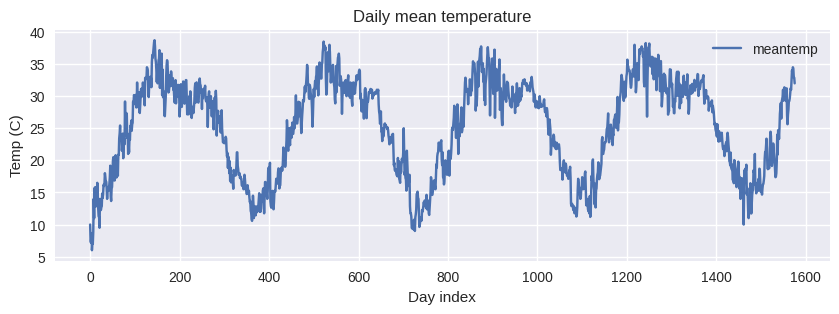

In [15]:
# Dataset + DataLoader
torch_X = torch.tensor(X_scaled, dtype=torch.float32).unsqueeze(-1)  # (N, window, 1)
torch_y = torch.tensor(y_scaled, dtype=torch.float32).unsqueeze(-1)

class SequenceDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

sequence_ds = SequenceDataset(torch_X, torch_y)
batch_size = 64
loader = DataLoader(sequence_ds, batch_size=batch_size, shuffle=False)

# Quick visual of the raw series
plt.figure(figsize=(10, 3))
plt.plot(meantemp_series.values, label='meantemp')
plt.title('Daily mean temperature')
plt.xlabel('Day index')
plt.ylabel('Temp (C)')
plt.legend()
plt.show()


## Vanilla LSTM model (Q3c)
- Input: sequence of 10 values (1 feature each).
- Output: next value.
- Loss: MSE.


In [16]:
class TempLSTM(nn.Module):
    def __init__(self, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
        )
        self.head = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.head(last)


def train_regression(model, loader, epochs=50, lr=1e-3, clip=1.0):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = []
    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb.squeeze(-1)) if preds.ndim == 2 else criterion(preds, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
        epoch_loss = running_loss / len(loader.dataset)
        history.append(epoch_loss)
        if epoch % 10 == 0 or epoch == 1:
            print(f'Epoch {epoch:03d} loss={epoch_loss:.6f}')
    return history, criterion


Epoch 001 loss=0.204718


/home/omar-elmasaoudi/miniconda3/envs/ml_dev_env/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/omar-elmasaoudi/miniconda3/envs/ml_dev_env/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 010 loss=0.018521
Epoch 020 loss=0.016650
Epoch 030 loss=0.016258
Epoch 040 loss=0.016025
Epoch 050 loss=0.015829
Epoch 060 loss=0.015660


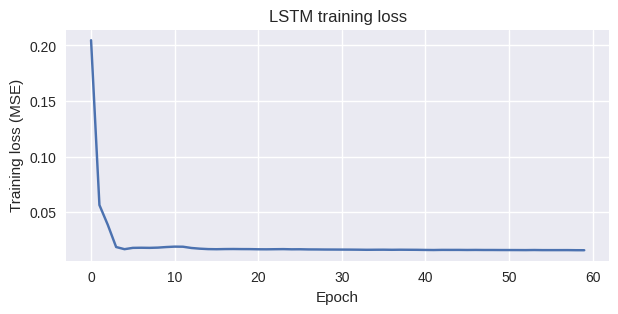

In [17]:
lstm_model = TempLSTM(hidden_size=96, num_layers=2, dropout=0.2).to(device)
lstm_history, lstm_criterion = train_regression(lstm_model, loader, epochs=60, lr=2e-3)

plt.figure(figsize=(7, 3))
plt.plot(lstm_history)
plt.xlabel('Epoch')
plt.ylabel('Training loss (MSE)')
plt.title('LSTM training loss')
plt.show()


## LSTM evaluation (Q3d)
We compare the predicted series (one-step ahead using the true previous 10 points) to the ground truth on the original scale.


LSTM MSE (original scale): 5.3001


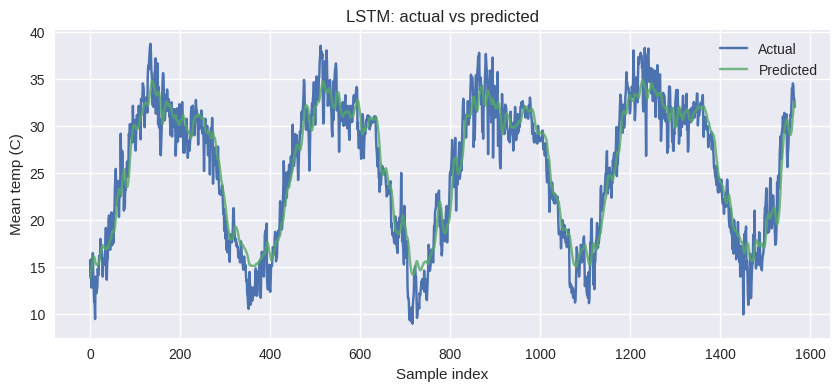

In [18]:
@torch.no_grad()
def predict_series(model, data_tensor):
    model.eval()
    preds = []
    for i in range(0, len(data_tensor), batch_size):
        xb = data_tensor[i:i + batch_size].to(device)
        out = model(xb).cpu().squeeze(-1)
        preds.append(out)
    return torch.cat(preds, dim=0)

lstm_scaled_preds = predict_series(lstm_model, torch_X)
lstm_preds = scaler.inverse_transform(lstm_scaled_preds.numpy().reshape(-1, 1)).flatten()
lstm_targets = scaler.inverse_transform(y_scaled.reshape(-1, 1)).flatten()

mse_lstm = mean_squared_error(lstm_targets, lstm_preds)
print(f'LSTM MSE (original scale): {mse_lstm:.4f}')

plt.figure(figsize=(10, 4))
plt.plot(lstm_targets, label='Actual')
plt.plot(lstm_preds, label='Predicted', alpha=0.8)
plt.xlabel('Sample index')
plt.ylabel('Mean temp (C)')
plt.title('LSTM: actual vs predicted')
plt.legend()
plt.show()


## Q4 Transformer-based model 
The transformer encoder processes the 10 step sequence. We reuse the same preprocessing and loader.


In [19]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)]
        return self.dropout(x)


class TempTransformer(nn.Module):
    def __init__(self, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(1, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True
        )
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.head = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        encoded = self.encoder(x)
        last = encoded[:, -1, :]
        return self.head(last)


Epoch 001 loss=0.119174


/home/omar-elmasaoudi/miniconda3/envs/ml_dev_env/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/omar-elmasaoudi/miniconda3/envs/ml_dev_env/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 010 loss=0.016760
Epoch 020 loss=0.016506
Epoch 030 loss=0.016527
Epoch 040 loss=0.016066
Epoch 050 loss=0.015990
Epoch 060 loss=0.015733
Epoch 070 loss=0.016118


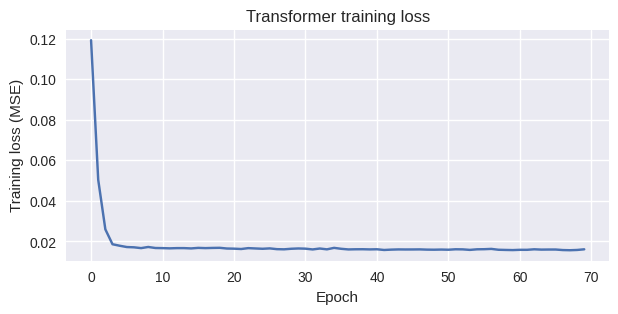

In [20]:
transformer_model = TempTransformer(d_model=64, nhead=4, num_layers=3, dim_feedforward=160, dropout=0.1).to(device)
trans_history, trans_criterion = train_regression(transformer_model, loader, epochs=70, lr=2e-3)

plt.figure(figsize=(7, 3))
plt.plot(trans_history)
plt.xlabel('Epoch')
plt.ylabel('Training loss (MSE)')
plt.title('Transformer training loss')
plt.show()


## Transformer evaluation and comparison


Transformer MSE (original scale): 6.0209


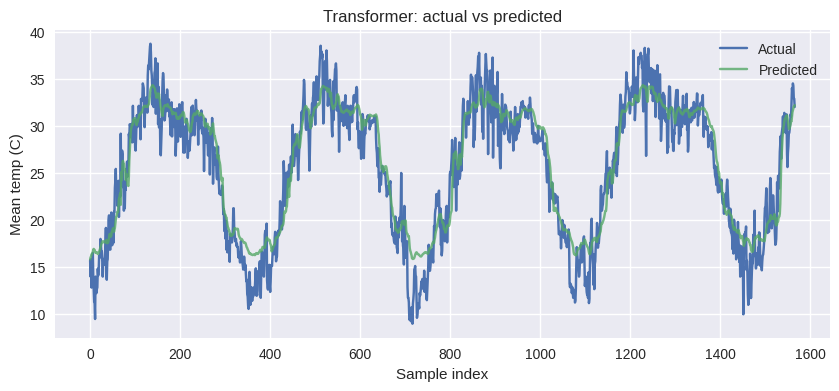

,model,mse
0,LSTM,5.300063
1,Transformer,6.020933


In [21]:
trans_scaled_preds = predict_series(transformer_model, torch_X)
trans_preds = scaler.inverse_transform(trans_scaled_preds.numpy().reshape(-1, 1)).flatten()

mse_trans = mean_squared_error(lstm_targets, trans_preds)
print(f'Transformer MSE (original scale): {mse_trans:.4f}')

plt.figure(figsize=(10, 4))
plt.plot(lstm_targets, label='Actual')
plt.plot(trans_preds, label='Predicted', alpha=0.8)
plt.xlabel('Sample index')
plt.ylabel('Mean temp (C)')
plt.title('Transformer: actual vs predicted')
plt.legend()
plt.show()

import pandas as pd
comparison = pd.DataFrame([
    {"model": "LSTM", "mse": mse_lstm},
    {"model": "Transformer", "mse": mse_trans},
])
comparison
